In [14]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from prediction.functions import aggregate_prediction_results
from time import time
import os
from word_list.basic import business, preis, huang

init = time()
plt.style.use('bmh')

In [15]:
models = ['logit', 'ridge', 'lasso', 'enet', 'random_forest', 'lgb', 'nn3']
fs_methods = ['all', 'sfi', 'mdi', 'mda', 'granger', 'huang', 'IAMB', 'MMMB']
tickers = ['SPX Index', 'CCMP Index','RTY Index', 'SPX Basic Materials',
           'SPX Communications', 'SPX Consumer Cyclical',
           'SPX Consumer Non cyclical', 'SPX Energy', 'SPX Financial',
           'SPX Industrial', 'SPX Technology', 'SPX Utilities']
benchmark_name = 'return_direction'
metric = "auc"

In [16]:
benchmarks = glob('data/indices/*.csv')
bench_list = []
for b in benchmarks:
    ticker = b.replace('data/indices/', '').replace('.csv', '')
    bench_ret_df = pd.read_csv(b)[3:]
    bench_ret_df.columns = ['date', 'return']
    bench_ret_df = bench_ret_df.melt('date')
    bench_ret_df['model'] = bench_ret_df['ticker'] = ticker
    bench_ret_df['fs'] = 'raw'

    bench_list.append(bench_ret_df)
benchmark_df = pd.concat(bench_list, axis=0)
benchmark_df['value'] = benchmark_df['value'].astype(float)
benchmark_df['date'] = pd.to_datetime(benchmark_df['date'])

In [17]:
ticker_df = benchmark_df.pivot_table(index=['date'],
                                     columns=['ticker'],
                                     values=['value'])
ticker_df = (1+ticker_df/100).cumprod()
ticker_df.columns = ticker_df.columns.droplevel() 
ticker_df = ticker_df.dropna()

melt_ticker_df = ticker_df.reset_index().melt('date')

### Cummulative returns for all U.S. market indices and some subgroups

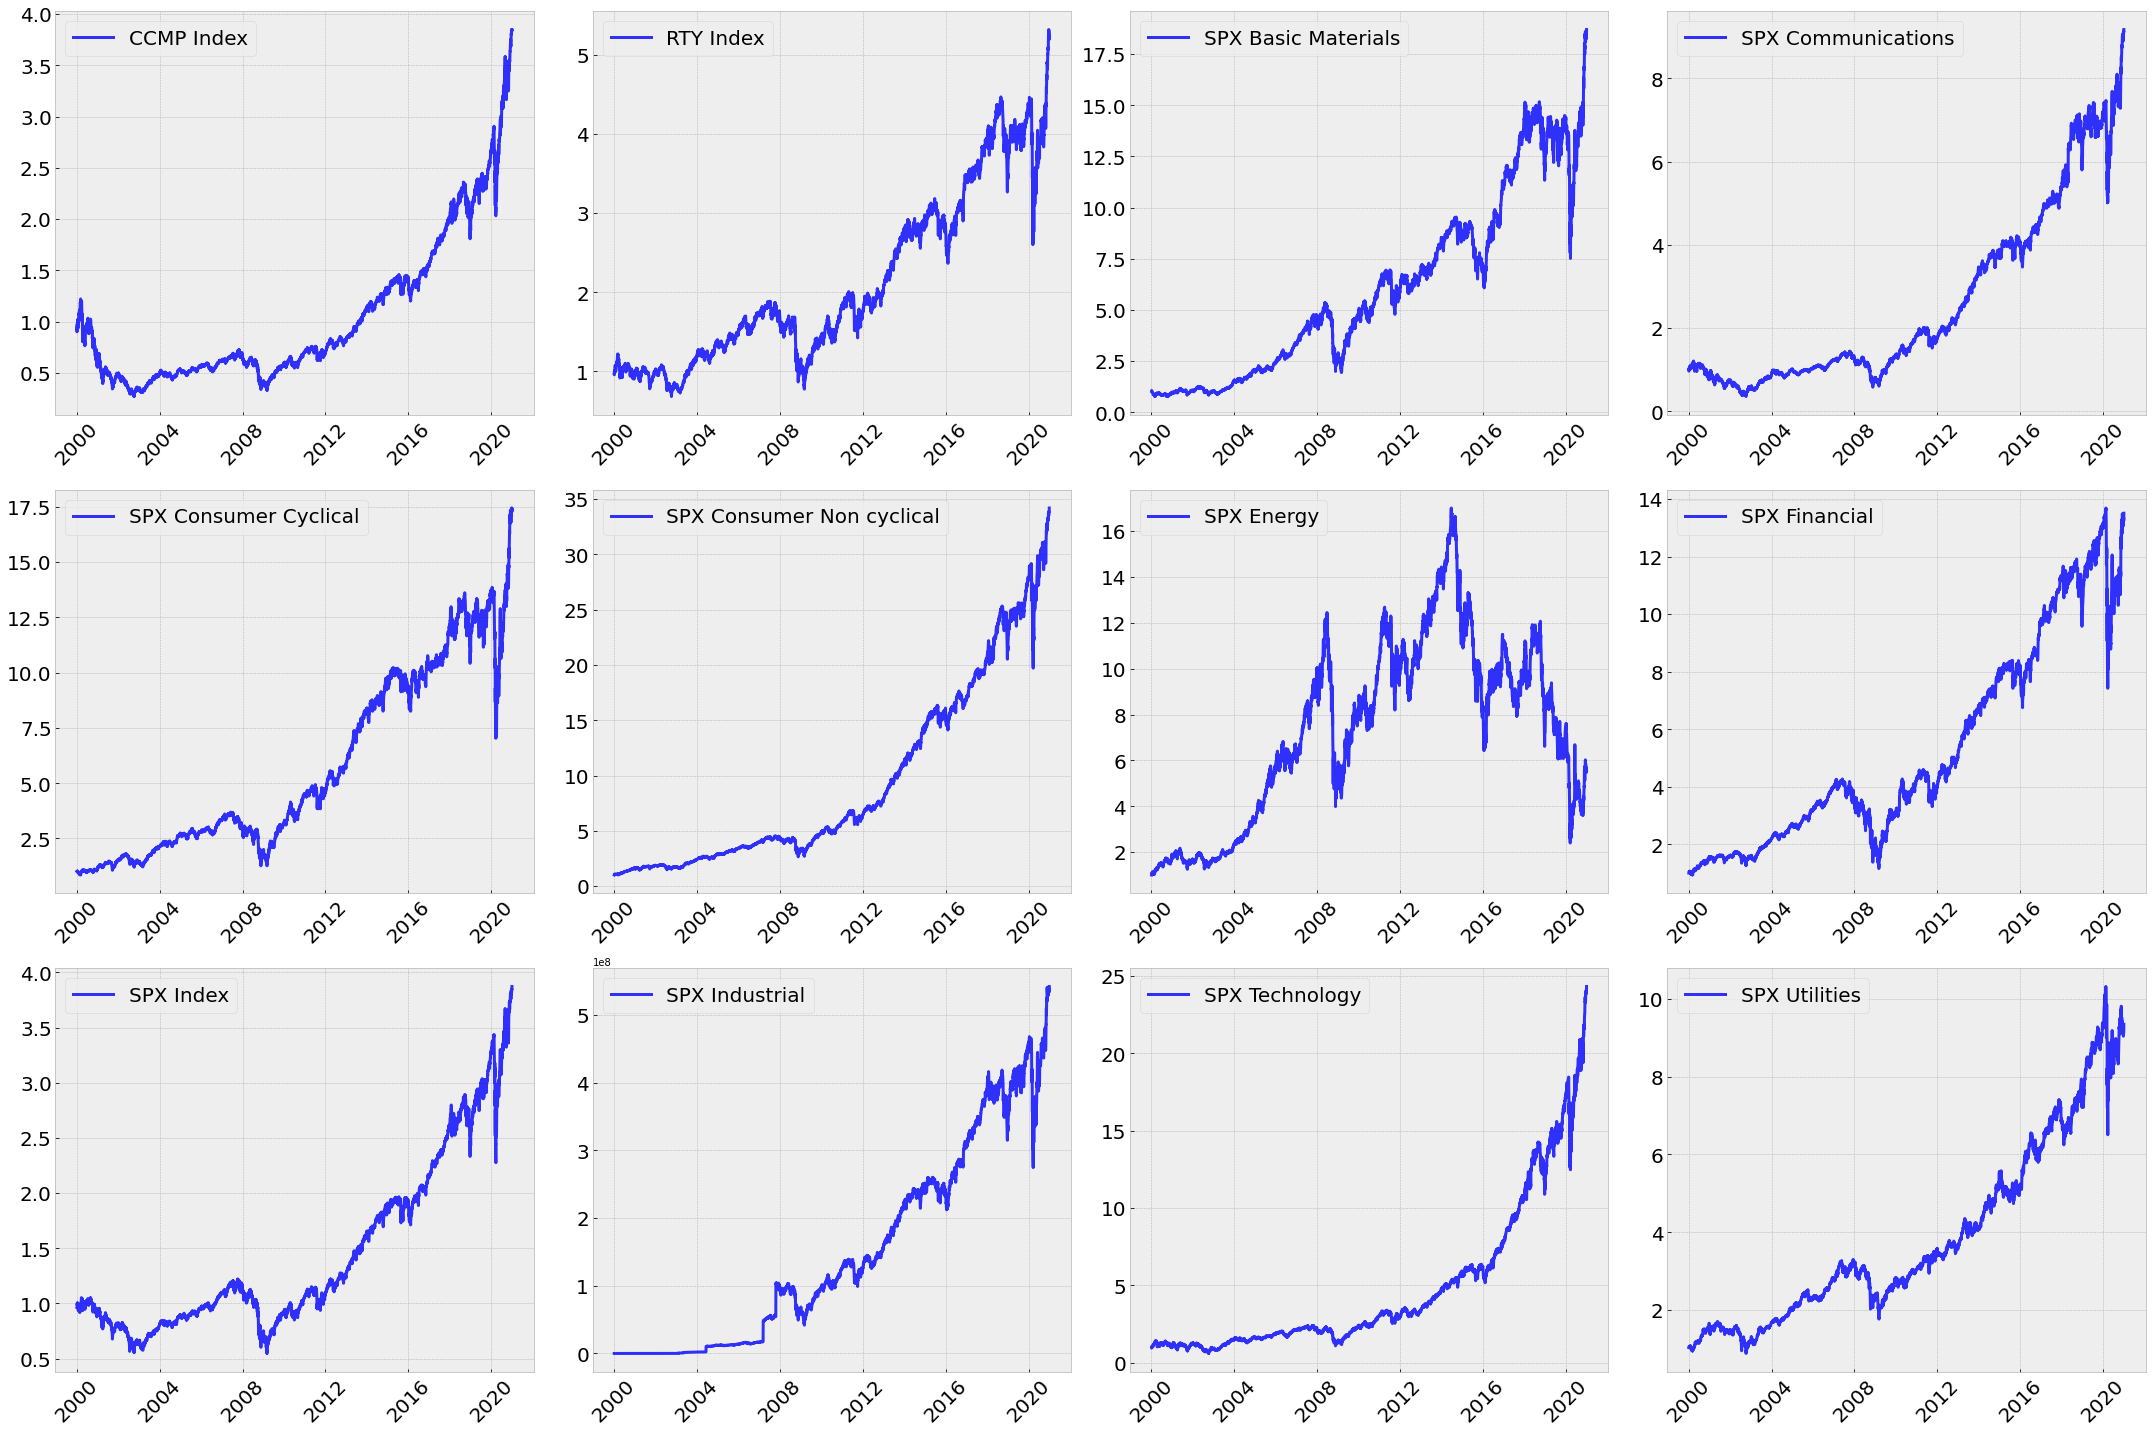

In [28]:
fig, ax = plt.subplots(3, 4,figsize=(30, 20))
for index, ticker in enumerate(ticker_df.columns):
    plt.subplot(3, 4, index+1)   
    plt.plot(ticker_df[ticker],
             label=ticker,
             linewidth=3,
             color='blue',
             linestyle= '-', 
             alpha=0.8)
                                      
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.tight_layout()   
plt.savefig(os.path.join('img', 'indices_cum_ret.png'), format='png', dpi=50)
plt.show()

### Table for different words by group

In [19]:
from word_list.basic import politics1, politics2, business

words_df = pd.DataFrame({'Politics 1': politics1, 
                         'Politics 2': politics2,
                         'Business': business})

In [20]:
print(words_df.to_latex(index=False))

\begin{tabular}{lll}
\toprule
      Politics 1 &  Politics 2 &     Business \\
\midrule
      republican &  notability &    blacklist \\
       wisconsin &       party &     business \\
            york &         law &   management \\
          county &  government &     services \\
          served &       court &    companies \\
          senate &    minister &  development \\
       president &   political &         bank \\
        district &         act &      founded \\
            ohio &   president &      million \\
        virginia &       votes &    financial \\
        carolina &      police &     industry \\
   massachusetts &     council &     products \\
    pennsylvania &    election &       global \\
      democratic &      rights &       market \\
        illinois &   elections &    marketing \\
 representatives &   committee &          ceo \\
      washington &  democratic &   technology \\
           texas &    security &   investment \\
        governor &       union

### Difference between Google Trends samples

In [21]:
base_daily_dfs_paths = glob("data/all_daily_trends/*")
base_daily_dfs_paths.sort()

In [22]:
def create_gtrends_data_using_base_path(base_path):
    """
    gather all data in the path "base_path" into
    a single dataframe.
    """
    trends_path = os.path.join(base_path,"*.csv")
    daily_dfs_path =  glob(trends_path)
    daily_dfs_path.sort()
    daily_dfs = [pd.read_csv(path) for path in daily_dfs_path]
    daily_dfs_names = [i.split("/")[3] for i in daily_dfs_path]
    daily_dfs_names = [i.split(".")[0] for i in daily_dfs_names]

    trends_list = []
    for name, df in zip(daily_dfs_names, daily_dfs):
        df.index = pd.to_datetime(df.date)
        ts = df[name]
        new_name = name.replace(" ", "_")
        ts.name = name
        trends_list.append(ts)

    trends = pd.concat(trends_list,1)
    trends = trends.fillna(0.0)
    columns = list(trends.columns)
    
    # checking the presence of the words 
    # that will be used in analysis
    
    assert [c for c in huang if c not in preis] == []
    assert [c for c in preis if c not in columns] == []
    assert [c for c in huang if c not in columns] == []
    assert [c for c in politics1 if c not in columns] == []
    assert [c for c in politics2 if c not in columns] == []
    assert [c for c in business if c not in columns] == []

    selected_words = politics1 + politics2 + business + preis
    selected_words = list(set(selected_words))
    selected_words.sort()
    # removing words with 0's only
    selected_words.remove("notability")
    selected_words.remove("rare earths")
    
    trends = trends[selected_words]
    trends = trends[:"2020-12-31"]
    return trends

In [24]:
df_list = [create_gtrends_data_using_base_path(p) for p in base_daily_dfs_paths]

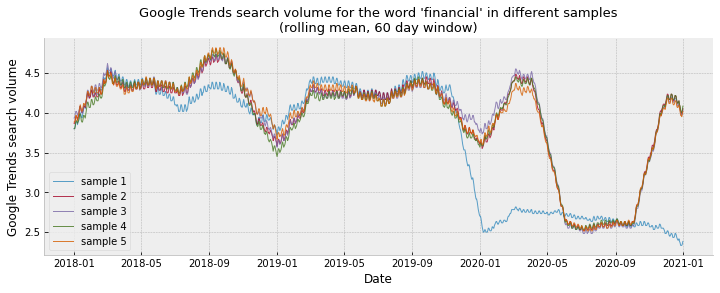

In [29]:
word = "financial"
window = 60
cut = [df[word] for df in df_list]

ex = pd.concat(cut,1)
ex.columns = ["sample {}".format(i+1) for i in range(len(cut))]
plot_df = ex.rolling(window).mean()["2018-01-01":]

title = "Google Trends search volume for the word '{}' in different samples".format(word)
title += "\n(rolling mean, {} day window)".format(window)

fig, ax = plt.subplots(figsize=(12,4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(label=title,
             fontsize=13)
for key in plot_df.columns:
    ax.plot(plot_df[key],
            label=key,
            linewidth=1,
            linestyle= '-', 
            alpha=0.8)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Google Trends search volume", fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.savefig(os.path.join('img', 'gtrends_samples.png'), format='png', dpi=100)
plt.show()